Top 10 defined-risk strategies by reward-to-risk:
     mask                                                        legs  num_legs  net_premium  max_gain  min_loss  rr
100663305   LONG C85 x1 + SHORT P85 x1 + SHORT C115 x1 + LONG P115 x1         4    29.775842  0.224158  0.224158 inf
  6291465   LONG C85 x1 + SHORT P85 x1 + SHORT C110 x1 + LONG P110 x1         4    24.813201  0.186799  0.186799 inf
100663440   LONG C90 x1 + SHORT P90 x1 + SHORT C115 x1 + LONG P115 x1         4    24.813201  0.186799  0.186799 inf
   393225   LONG C85 x1 + SHORT P85 x1 + SHORT C105 x1 + LONG P105 x1         4    19.850561  0.149439  0.149439 inf
  6291600   LONG C90 x1 + SHORT P90 x1 + SHORT C110 x1 + LONG P110 x1         4    19.850561  0.149439  0.149439 inf
100665600   LONG C95 x1 + SHORT P95 x1 + SHORT C115 x1 + LONG P115 x1         4    19.850561  0.149439  0.149439 inf
  6293760   LONG C95 x1 + SHORT P95 x1 + SHORT C110 x1 + LONG P110 x1         4    14.887921  0.112079  0.112079 inf
    24585   LO

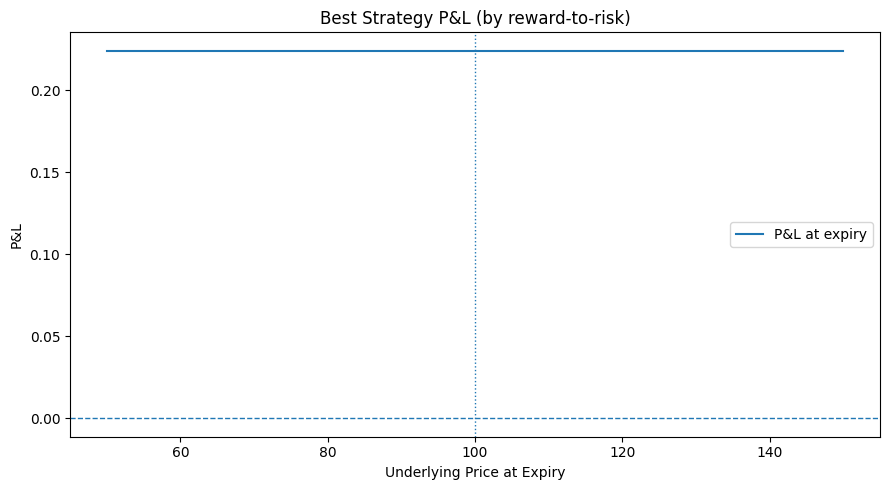

In [1]:
# Step 19 — Bit Manipulation + Option Combination Sets
# Enumerate multi-leg strategies via bitmasks, compute payoff curves, and rank.
import math, itertools
from dataclasses import dataclass
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------- Black–Scholes (no dividends) --------------------
from math import log, sqrt, exp
from scipy.stats import norm

def bs_call_put(S, K, T, r, sigma):
    """Return (call, put) Black–Scholes prices."""
    if T <= 0 or sigma <= 0:
        # Intrinsic only fallback
        call = max(S - K, 0.0)
        put = max(K - S, 0.0)
        return call, put
    d1 = (log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    call = S*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)
    put  = K*exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    return call, put

# -------------------- Data model --------------------
@dataclass(frozen=True)
class Leg:
    # An option leg specification
    kind: str     # "C" or "P"
    K: float
    side: int     # +1 long, -1 short
    qty: int
    premium: float  # per 1x contract (we treat qty as multiplicative)
    key: str      # contract key, e.g., "C-100"

    def payoff(self, ST: np.ndarray) -> np.ndarray:
        if self.kind == "C":
            terminal = np.maximum(ST - self.K, 0.0)
        else:
            terminal = np.maximum(self.K - ST, 0.0)
        return self.side * self.qty * terminal

    def premium_total(self) -> float:
        # Long pays (+premium), short receives (-premium) when computing P&L as payoff - cost
        # We'll define P&L = payoff - cost; so long = +premium; short = -premium
        return self.qty * self.premium * (1 if self.side > 0 else -1)

# -------------------- Build synthetic chain --------------------
def build_chain(S0=100.0, r=0.03, T=0.25, sigma=0.25, strikes=None):
    if strikes is None:
        strikes = np.arange(80, 121, 5, dtype=float)  # 80..120 step 5
    rows = []
    for K in strikes:
        c, p = bs_call_put(S0, K, T, r, sigma)
        rows.append(("C", K, c))
        rows.append(("P", K, p))
    chain = pd.DataFrame(rows, columns=["kind","K","mid"])
    chain["key"] = chain["kind"] + "-" + chain["K"].astype(int).astype(str)
    return chain, dict(S0=S0, r=r, T=T, sigma=sigma)

# -------------------- Build candidate leg menu --------------------
def build_leg_menu(chain: pd.DataFrame, longs=True, shorts=True, qty=1) -> List[Leg]:
    legs: List[Leg] = []
    for _, row in chain.iterrows():
        k, K, mid = row["kind"], float(row["K"]), float(row["mid"])
        key = f"{k}-{int(K)}"
        if longs:
            legs.append(Leg(k, K, +1, qty, mid, key))   # buy option (pay premium)
        if shorts:
            legs.append(Leg(k, K, -1, qty, mid, key))   # sell option (receive premium)
    return legs

# -------------------- Exclusions: no long and short of same contract --------------------
def build_exclusion_bitmasks(legs: List[Leg]) -> Dict[str, Tuple[int,int]]:
    """
    For each contract key, find indices for long and short; disallow selecting both.
    Return mapping key -> (i_long, i_short). If one side missing, omit.
    """
    pos: Dict[str, Dict[int,int]] = {}
    for i, leg in enumerate(legs):
        pos.setdefault(leg.key, {})
        pos[leg.key][leg.side] = i
    excl = {}
    for key, d in pos.items():
        if +1 in d and -1 in d:
            excl[key] = (d[+1], d[-1])
    return excl

# -------------------- Strategy enumeration via bitmasks --------------------
def evaluate_strategy(mask: int, legs: List[Leg], ST: np.ndarray) -> Tuple[float,float,float,np.ndarray]:
    """
    Return (max_gain, min_loss, rr, pnl_curve) where rr = max_gain / max(1e-9, |min_loss|)
    P&L = sum(leg payoff) - sum(leg premiums with sign convention implemented in premium_total()).
    """
    selected = [legs[i] for i in range(len(legs)) if (mask >> i) & 1]
    if not selected:
        return -np.inf, np.inf, 0.0, np.zeros_like(ST)
    payoff = sum((leg.payoff(ST) for leg in selected), start=np.zeros_like(ST))
    cost   = sum((leg.premium_total() for leg in selected))
    pnl    = payoff - cost
    max_gain = float(np.max(pnl))
    min_loss = float(np.min(pnl))
    rr = max_gain / max(1e-9, abs(min_loss)) if min_loss < 0 else np.inf  # if never loses on grid, rr=inf
    return max_gain, min_loss, rr, pnl

def is_defined_risk(pnl: np.ndarray, tol=5.0) -> bool:
    """
    Heuristic: strategy is 'defined risk' if losses are bounded in our wide grid.
    Require (min pnl) > -X huge and both tails not trending to -inf within grid.
    We check that the first and last 5% windows don't keep decreasing.
    """
    n = len(pnl)
    if n < 20:
        return True
    left  = pnl[: max(2, n//20)]
    right = pnl[-max(2, n//20):]
    # simple boundedness check within grid
    finite_ok = np.isfinite(pnl).all() and (np.min(pnl) > -1e6)
    # edges should not be dramatically worse than interior (rough guard)
    edge_not_horrible = (np.min(left)  >= np.min(pnl) - tol) and (np.min(right) >= np.min(pnl) - tol)
    return finite_ok and edge_not_horrible

def enumerate_strategies(legs: List[Leg], ST: np.ndarray, max_legs=4, top_k=10) -> pd.DataFrame:
    n = len(legs)
    excl = build_exclusion_bitmasks(legs)
    # precompute pair bitmasks for fast rejection
    excl_masks = []
    for pair in excl.values():
        m = (1 << pair[0]) | (1 << pair[1])
        excl_masks.append(m)

    best_rows = []
    for mask in range(1, 1 << n):
        # prune by leg count
        if (bits := mask.bit_count()) > max_legs:
            continue
        # reject if contains both sides of any contract
        illegal = False
        for m in excl_masks:
            if (mask & m) == m:
                illegal = True; break
        if illegal:
            continue

        max_gain, min_loss, rr, pnl = evaluate_strategy(mask, legs, ST)
        # must have at least one long or short? Already guaranteed; we have subset non-empty
        # quick defined risk check
        if not is_defined_risk(pnl):
            continue

        # summarize legs
        sel = [legs[i] for i in range(n) if (mask >> i) & 1]
        desc = " + ".join([f"{'LONG' if s.side>0 else 'SHORT'} {s.kind}{int(s.K)} x{s.qty}" for s in sel])
        cost = sum((leg.premium_total() for leg in sel))
        best_rows.append({
            "mask": mask,
            "legs": desc,
            "num_legs": bits,
            "net_premium": cost,              # cost>0: debit, cost<0: credit
            "max_gain": max_gain,
            "min_loss": min_loss,
            "rr": rr
        })

    if not best_rows:
        return pd.DataFrame(columns=["mask","legs","num_legs","net_premium","max_gain","min_loss","rr"]).sort_values("rr", ascending=False)

    df = pd.DataFrame(best_rows)
    df.sort_values(["rr","max_gain"], ascending=[False, False], inplace=True)
    return df.head(top_k)

# -------------------- Run a demo --------------------
S0 = 100.0
r  = 0.03
T  = 0.25
sigma = 0.25

chain, params = build_chain(S0=S0, r=r, T=T, sigma=sigma, strikes=np.arange(85, 116, 5))
menu = build_leg_menu(chain, longs=True, shorts=True, qty=1)

# Price grid (wide enough to judge risk)
ST = np.linspace(50, 150, 801)

# Enumerate and rank
top = enumerate_strategies(menu, ST, max_legs=4, top_k=10)
print("Top 10 defined-risk strategies by reward-to-risk:")
print(top.to_string(index=False))

# Plot the best one
if len(top):
    best_mask = int(top.iloc[0]["mask"])
    sel_legs = [menu[i] for i in range(len(menu)) if (best_mask >> i) & 1]
    _, _, _, pnl_curve = evaluate_strategy(best_mask, menu, ST)
    print("\nBest strategy legs:")
    for lg in sel_legs:
        print(f" - {'LONG' if lg.side>0 else 'SHORT'} {lg.kind}{int(lg.K)} x{lg.qty} (premium {lg.premium:.2f})")
    # Zero-cost line and ATM
    plt.figure(figsize=(9,5))
    plt.plot(ST, pnl_curve, label="P&L at expiry")
    plt.axhline(0, lw=1, ls="--")
    plt.axvline(S0, lw=1, ls=":")
    plt.title("Best Strategy P&L (by reward-to-risk)")
    plt.xlabel("Underlying Price at Expiry")
    plt.ylabel("P&L")
    plt.legend(); plt.tight_layout(); plt.show()
